# 1) Prepare X_train, X_val, y_train, y_val

In [1]:
import LoadAndPreprocessDataset

In [2]:
#Load filenames
train,val,test = LoadAndPreprocessDataset.loadDatasetFilenames()

#Load TRAIN files
X,y_train=LoadAndPreprocessDataset.loadBatch(train,batch_size=30000)
#Preprocess TRAIN
#X_train=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
X_train=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#X_train=LoadAndPreprocessDataset.melspect(X)
#X_train=X #No preprocessing
#Release memory
del(X)

#Load VAL files
X,y_val=LoadAndPreprocessDataset.loadBatch(val,batch_size=3000)
#Preprocess VAL
#X_val=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
X_val=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#X_val=LoadAndPreprocessDataset.melspect(X)
#X_val=X #No preprocessing
#Release memory
del(X)

print(X_train.shape,X_val.shape)


# NORMALIZATION
### NO normalization seems better
#from sklearn.preprocessing import normalize
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1,1)) # Gives huge bias
#for i in range(len(X_train)):
    #X_train[i]=normalize(X_train[i], axis=0, norm='max') #normalize each feature of the example
    #X_train[i]=(X_train[i] - X_train[i].min(0)) / X_train[i].ptp(0) # HUGE BIAS
    #X_train[i]=scaler.fit_transform(X_train[i]) # HUGE BIAS
#for i in range(len(X_val)):
    #X_val[i]=normalize(X_val[i], axis=0, norm='max') #normalize each feature of the example
    #X_val[i]=(X_val[i] - X_val[i].min(0)) / X_val[i].ptp(0) #HUGE BIAS
    #X_val[i]=scaler.fit_transform(X_val[i])  # HUGE BIAS


#ADD extra dimension for CNN
import numpy as np
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
print(X_train.shape,X_val.shape)


print('X_train uses',X_train.shape[0],"of",len(train),"files")
print('X_val uses',X_val.shape[0],"of",len(val),"files")

(30000, 40, 126) (3000, 40, 126)
(30000, 40, 126, 1) (3000, 40, 126, 1)
X_train uses 30000 of 30769 files
X_val uses 3000 of 3703 files


(30000, 40, 126, 1)
(30000,)
(3000, 40, 126, 1)
(3000,)


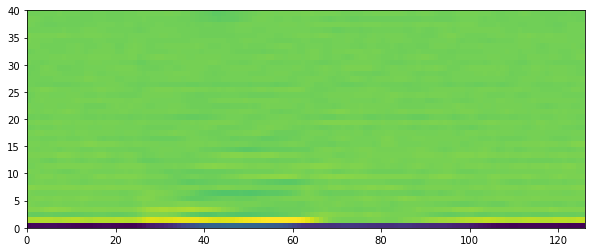

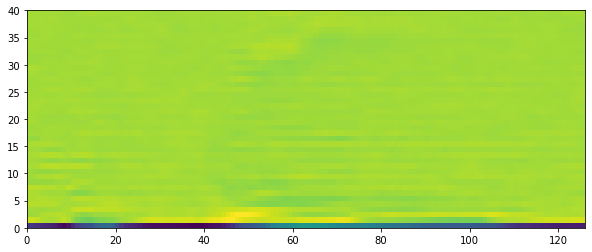

-715.541748046875
156.43775939941406


'for i in range(len(X_train[1])):\n    print(i,np.min(X_train[1,i]),np.max(X_train[1,i]))\nprint(X_train[1].shape)'

In [3]:
# Look at some data

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.pcolormesh(X_train[0,:,:,0])
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(X_val[0,:,:,0])
plt.show()

import numpy as np
print(np.min(X_train))
print(np.max(X_train))

'''for i in range(len(X_train[1])):
    print(i,np.min(X_train[1,i]),np.max(X_train[1,i]))
print(X_train[1].shape)'''

----------------------------------------------------

# 2) Model


## Define NN

In [4]:
import Models

In [5]:
categories=['yes','no','up','down','left','right','on','off','stop','go']
nCategories=len(categories)


import datetime
modelName="DSConvModelMedium"
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_"+modelName

'''model = Models.LeNet5(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)
model = Models.AttRNNSpeechModel(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)
model = Models.directCNN(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)'''
model = Models.DSConvModelMedium(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)

model.compile(optimizer='nadam',
              loss=['sparse_categorical_crossentropy'],
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "DSConvModelMedium"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 126, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 63, 172)       7052      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 63, 172)       688       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 19, 31, 172)       1720      
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 31, 172)       688       
_________________________________________________________________
activation (Activation)      (None, 19, 31, 172)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 31, 172) 

## Train NN

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
import math


log_dir = "logs\\"+save_name

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

def performance_scheduling(epoch):
    #.....
    return lrate

my_callbacks = [
    EarlyStopping(monitor='val_sparse_categorical_accuracy',
                  patience=20,
                  verbose=1,
                  restore_best_weights=True),
    ModelCheckpoint('models/'+save_name+'.h5',
                    monitor='val_sparse_categorical_accuracy',
                    verbose=1,
                    save_best_only=True),
    TensorBoard(log_dir=log_dir,histogram_freq=1)]
    #lrate]


In [7]:
#Train
results = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    batch_size=32, # usually between 10 and 32
                    epochs=100,
                    callbacks=my_callbacks,
                    verbose=1)

#model.save('models/'+modelName+'.h5')

Train on 30000 samples, validate on 3000 samples
Epoch 1/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.7563 - sparse_categorical_accuracy: 0.7495
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.88500, saving model to models/2020-07-25_11-22_DSConvModelMedium.h5
30000/30000 [==============================] - 105s 4ms/sample - loss: 0.7561 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.3604 - val_sparse_categorical_accuracy: 0.8850
Epoch 2/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.2571 - sparse_categorical_accuracy: 0.9148
Epoch 00002: val_sparse_categorical_accuracy improved from 0.88500 to 0.91133, saving model to models/2020-07-25_11-22_DSConvModelMedium.h5
30000/30000 [==============================] - 101s 3ms/sample - loss: 0.2571 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.3058 - val_sparse_categorical_accuracy: 0.9113
Epoch 3/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.192

29984/30000 [============================>.] - ETA: 0s - loss: 0.0272 - sparse_categorical_accuracy: 0.9913- ETA: 1s - loss: 0.0269 - sparse_categorical_acc
Epoch 00021: val_sparse_categorical_accuracy did not improve from 0.94467
30000/30000 [==============================] - 102s 3ms/sample - loss: 0.0271 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.4025 - val_sparse_categorical_accuracy: 0.9257
Epoch 22/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.0234 - sparse_categorical_accuracy: 0.9929
Epoch 00022: val_sparse_categorical_accuracy did not improve from 0.94467
30000/30000 [==============================] - 101s 3ms/sample - loss: 0.0234 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.9433
Epoch 23/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.0240 - sparse_categorical_accuracy: 0.9928
Epoch 00023: val_sparse_categorical_accuracy improved from 0.94467 to 0.94900, saving model to mode

Epoch 43/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.0096 - sparse_categorical_accuracy: 0.9970
Epoch 00043: val_sparse_categorical_accuracy did not improve from 0.94967
30000/30000 [==============================] - 86s 3ms/sample - loss: 0.0096 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.9380
Epoch 44/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.0118 - sparse_categorical_accuracy: 0.9962
Epoch 00044: val_sparse_categorical_accuracy did not improve from 0.94967
30000/30000 [==============================] - 86s 3ms/sample - loss: 0.0118 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.4035 - val_sparse_categorical_accuracy: 0.9410
Epoch 45/100
29984/30000 [============================>.] - ETA: 0s - loss: 0.0100 - sparse_categorical_accuracy: 0.9966Restoring model weights from the end of the best epoch.

Epoch 00045: val_sparse_categorical_accuracy did not improve from 0.94967
30000/3

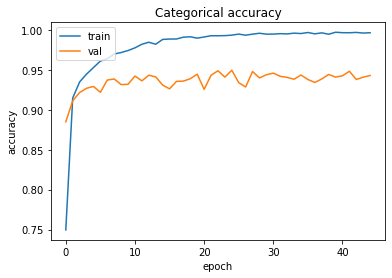

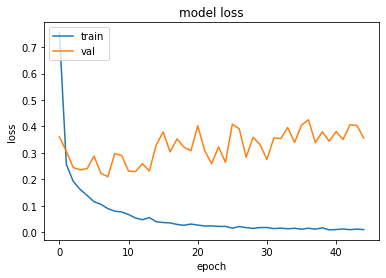

In [8]:
import matplotlib.pyplot as plt

save_dir="output/"+save_name+"_"

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Categorical Accuracy", dpi=400)
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Loss", dpi=400)
plt.show()



--------------------------------------------

# 3) Test the model

In [9]:
#Load TEST file
X,y_test=LoadAndPreprocessDataset.loadBatch(val,batch_size=3000)
#Preprocess TEST
#X_test=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
X_test=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#X_test=LoadAndPreprocessDataset.melspect(X)
#X_test=X
#Release memory
del(X)

#ADD extra dimension for CNN
import numpy as np
X_test = X_test[..., np.newaxis]

In [10]:
#load best model
from tensorflow.keras.models import load_model
model = load_model('models/'+save_name+'.h5')

# Test the model on test data
import numpy as np
score = model.evaluate(X_test, y_test)
y_pred=np.argmax(model.predict(X_test),1)


#Measure time for every single prediction
"""import time

s=time.time()
y_pred=np.argmax(model.predict(X_test[:500,:,:]),1)
e=time.time()
print("Entire:",e-s)

starts=np.empty((len(X_test),))
ends=np.empty((len(X_test),))
for i in range(len(X_test)):
    a=np.array([X_test[i]])
    starts[i]=time.time()
    a=np.argmax(model.predict(a),1)
    ends[i]=time.time()
average=sum(ends-starts)/len(X_test)
print("Average single prediction time (s):",average)"""

# 1 prediction or a batch of 10 requires the same amount of time
# a batch of 100 prediction requires the double of 1
# a batch of 500 prediction requires the 3 times of 1

3000/3000 [==============================] - 2s 779us/sample - loss: 0.2659 - sparse_categorical_accuracy: 0.9500s - loss: 0.2357 - sparse_categor


'import time\n\ns=time.time()\ny_pred=np.argmax(model.predict(X_test[:500,:,:]),1)\ne=time.time()\nprint("Entire:",e-s)\n\nstarts=np.empty((len(X_test),))\nends=np.empty((len(X_test),))\nfor i in range(len(X_test)):\n    a=np.array([X_test[i]])\n    starts[i]=time.time()\n    a=np.argmax(model.predict(a),1)\n    ends[i]=time.time()\naverage=sum(ends-starts)/len(X_test)\nprint("Average single prediction time (s):",average)'

# 4) Metrics Summary

Train loss:	 0.01
Train accuracy:	 0.997
Val loss:	 0.356
Val accuracy:	 0.943
Test loss:	 0.266
Test accuracy:	 0.95
Bias:		 0.003
Variance:	 0.054
Precision:	 0.95
Recall:		 0.95
F1:		 0.95


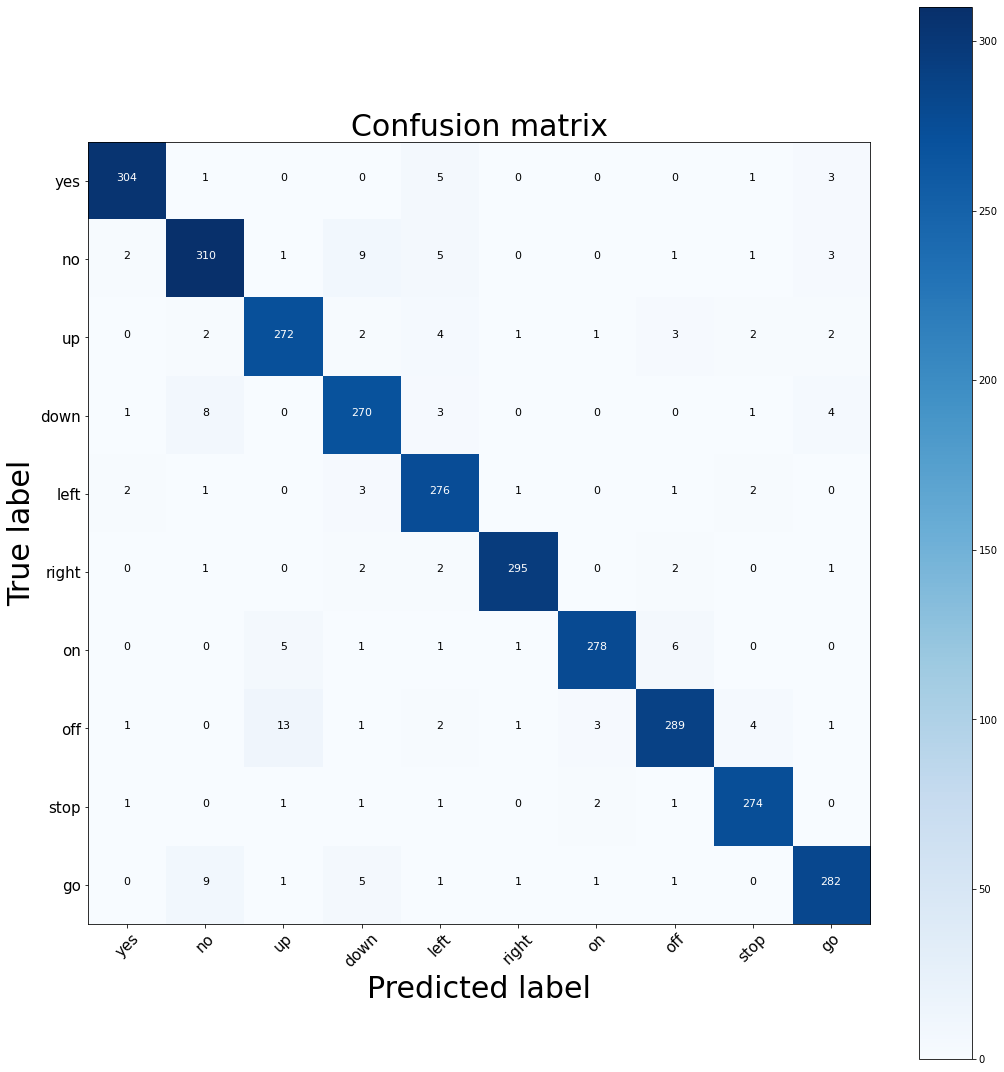

In [11]:
train_loss=results.history.get('loss')[-1]
val_loss=results.history.get('val_loss')[-1]

train_error=1-results.history.get('sparse_categorical_accuracy')[-1]
val_error=1-results.history.get('val_sparse_categorical_accuracy')[-1]

test_loss=score[0]
test_error=1-score[1]

print('Train loss:\t', round(train_loss,3))
print('Train accuracy:\t', round(1-train_error,3))
print('Val loss:\t', round(val_loss,3))
print('Val accuracy:\t', round(1-val_error,3))
print('Test loss:\t', round(test_loss,3))
print('Test accuracy:\t', round(score[1],3))

optimal_error=0.00 #human error

bias=train_error-optimal_error
variance=val_error-train_error
print("Bias:\t\t",round(bias,3))
print("Variance:\t",round(variance,3))


# Precision and Recall(sensitivity/true positive rate)
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_test, y_pred,average='micro')
rec=recall_score(y_test, y_pred,average='micro')

#F1 - high if both recall and precision are high.
from sklearn.metrics import f1_score
f1=f1_score(y_test, y_pred,average='micro')

print("Precision:\t",round(prec,3))
print("Recall:\t\t",round(rec,3))
print("F1:\t\t",round(f1,3))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
import audioUtils
audioUtils.plot_confusion_matrix(cm,categories, normalize=False,save_path=save_dir)



# SAVE MODEL SUMMARY and METRICS TO FILE
f = open(save_dir+"Metrics.txt", "a")

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
f.write(short_model_summary+"\n\n")

f.write('Train loss:\t'+ str(round(train_loss,3))+ "\n")
f.write('Train accuracy:\t'+ str((round(1-train_error,3)))+ "\n")
f.write('Val loss:\t'+ str(round(val_loss,3))+ "\n")
f.write('Val accuracy:\t'+ str((round(1-val_error,3)))+ "\n")
f.write('Test loss:\t'+ str(round(test_loss,3))+ "\n")
f.write('Test accuracy:\t'+ str(round(score[1],3))+ "\n")
f.write("Bias:\t\t"+str(round(bias,3))+ "\n")
f.write("Variance:\t"+str(round(variance,3))+ "\n")
f.write("Precision:\t"+str(round(prec,3))+ "\n")
f.write("Recall:\t\t"+str(round(rec,3))+ "\n")
f.write("F1:\t\t"+str(round(f1,3)))
f.close()